In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import mlflow
import random
import matplotlib.pyplot as plt
from varname import nameof
from fastapi import FastAPI
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_score, recall_score, log_loss, f1_score, roc_auc_score, \
confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix
from IPython.display import Image
from yellowbrick.classifier import ROCAUC
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping

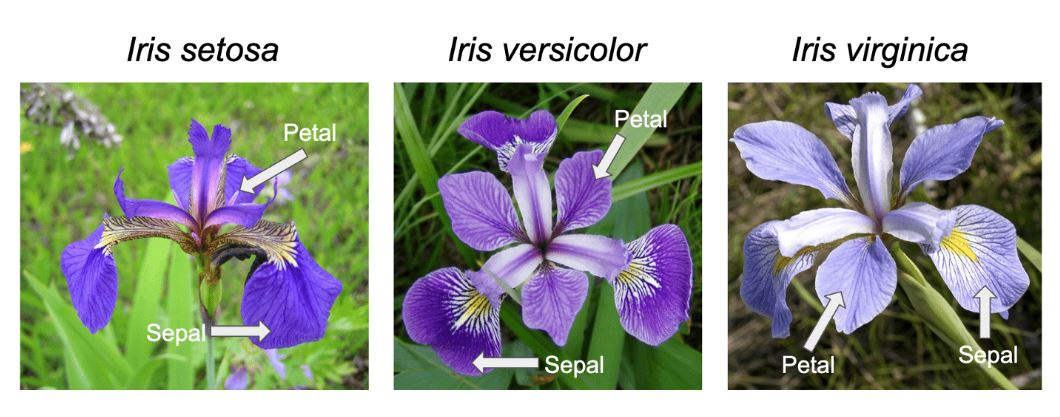

In [2]:
Image.open('iris_data\iris_types.JPG') 

# MLFlow functions

In [3]:
# create a default image
not_available = "iris_data/not_available.png"
fnt = ImageFont.truetype('arial.ttf', 150)
image = Image.new(mode = "RGB", size = (900,200), color = "red")
draw = ImageDraw.Draw(image)
draw.text((10,10), "Not Available", font=fnt, fill=(255,255,0))
image.save(not_available)

# setting minimum score for PROD
to_PROD_score = 0.93

def create_experiment(experiment_name, run_metrics, model, envir, 
                      confusion_matrix_path, roc_auc_path = not_available, run_params=None):

    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
     
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
            
        mlflow.sklearn.log_model(model, "model")
        mlflow.set_tags({"Model":model, "Environment":envir})
        mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
        mlflow.log_artifact(roc_auc_path, 'roc_auc')

#         if not run_params == None:
#             for param in run_params:
#                 mlflow.log_param(param, run_params[param])


def get_metrics(y_test, y_best_pred, y_best_pred_proba):
    accuracy = accuracy_score(y_test, y_best_pred)
    precision = precision_score(y_test, y_best_pred, average='weighted') 
    recall = recall_score(y_test, y_best_pred, average='weighted') 
    f1 = f1_score(y_test, y_best_pred, average='weighted')
    return {'accuracy': round(accuracy, 3),              
            'precision': round(precision, 3), 
            'recall': round(recall, 3),
            'f1': round(recall, 3)}


def create_confusion_matrix_plot(best_model, X_test, y_test, file_name_cm):
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
    plt.grid(False)
    plt.savefig(file_name_cm)

# Iris Dataset

In [4]:
iris_data_columns = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
iris_data = pd.read_csv("iris_data\iris_data.csv", header=0, names=iris_data_columns)
iris_data.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Features distribution and relations

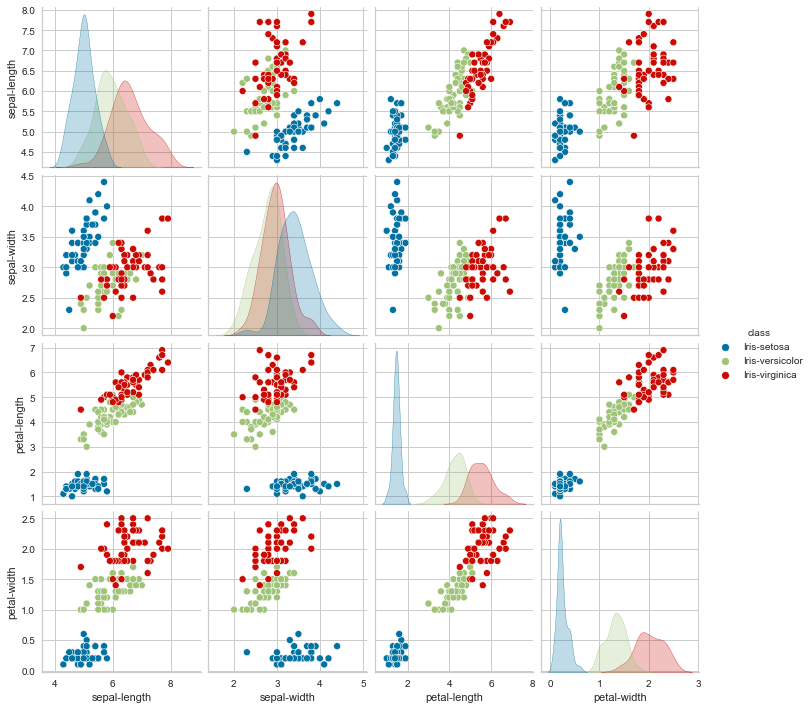

In [5]:
sns.pairplot(iris_data, hue='class')

# Class distribution per feature

In [6]:
encoder = LabelEncoder()
iris_data['class_encoded'] = encoder.fit_transform(iris_data['class'])

#correlation between each input feature and the output feature
iris_data.corr()['class_encoded']

C:\Users\e105695\AppData\Local\Temp\ipykernel_8588\3104278588.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  iris_data.corr()['class_encoded']


sepal-length     0.782561
sepal-width     -0.419446
petal-length     0.949043
petal-width      0.956464
class_encoded    1.000000
Name: class_encoded, dtype: float64

[Text(0, 0, 'Iris-setosa'),
 Text(1, 0, 'Iris-versicolor'),
 Text(2, 0, 'Iris-virginica')]

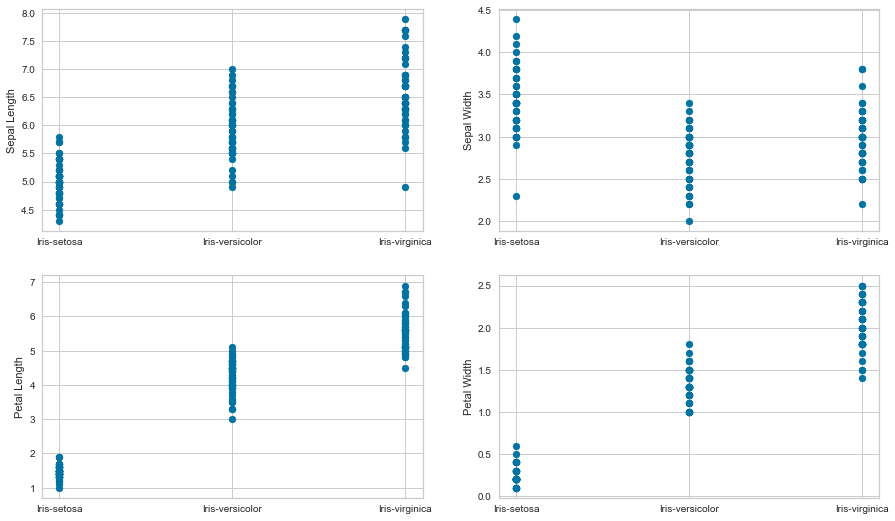

In [7]:
#label for plots
class_labels = iris_data['class'].unique()
class_labels_encoded = iris_data['class_encoded'].unique()

fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,9))
 
ax1.scatter(x = iris_data['class_encoded'], y = iris_data['sepal-length'])
ax1.set_ylabel("Sepal Length")
ax1.set_xticks(class_labels_encoded)
ax1.set_xticklabels(class_labels)
 
ax2.scatter(x = iris_data['class_encoded'], y = iris_data['sepal-width'])
ax2.set_ylabel("Sepal Width")
ax2.set_xticks(class_labels_encoded)
ax2.set_xticklabels(class_labels)
 
ax3.scatter(x = iris_data['class_encoded'], y = iris_data['petal-length'])
ax3.set_ylabel("Petal Length")
ax3.set_xticks(class_labels_encoded)
ax3.set_xticklabels(class_labels)
 
ax4.scatter(x = iris_data['class_encoded'], y = iris_data['petal-width'])
ax4.set_ylabel("Petal Width")
ax4.set_xticks(class_labels_encoded)
ax4.set_xticklabels(class_labels)

# Features & Labels definition and scaling

In [8]:
X = iris_data.drop(['class_encoded','class'], axis=1)
y = iris_data['class_encoded']
X.columns

Index(['sepal-length', 'sepal-width', 'petal-length', 'petal-width'], dtype='object')

In [9]:
X_train_notscaled, X_test_notscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [10]:
#scale the input features to mean=0 and std=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_notscaled.values)
X_test_scaled = scaler.transform(X_test_notscaled.values)

In [11]:
pickle.dump(scaler, open('iris_models\iris_scaler.pkl','wb'))

# Features reduction TSNE

C:\Users\e105695\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


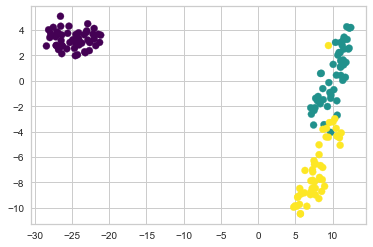

In [12]:
model_tsne = TSNE(learning_rate=100, init='pca')
transformed_tsne = model_tsne.fit_transform(X.values)
xs = transformed_tsne[:,0]
ys = transformed_tsne[:,1]
plt.scatter(xs, ys, c=y, cmap='viridis')
plt.show()

# Features reduction PCA

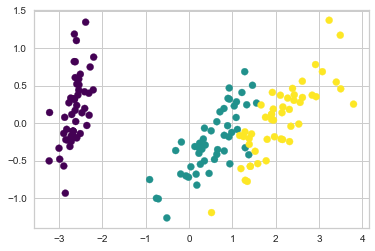

In [13]:
pca = PCA(n_components=2)
pca.fit(X.values)
transformed_pca = pca.transform(X.values)
xs = transformed_pca[:,0]
ys = transformed_pca[:,1]
plt.scatter(xs, ys, c=y, cmap='viridis')
plt.show()

# KMeans

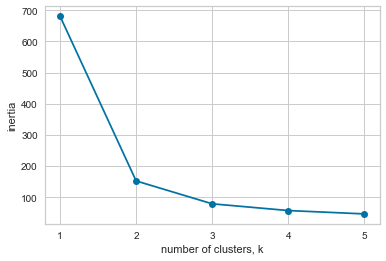

In [14]:
ks = range(1, 6)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model_km = KMeans(n_clusters=k)
    
    # Fit model to samples
    model_km.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model_km.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [15]:
#re-fitting the model witn 3 clusters

model_km = KMeans(n_clusters=3, random_state=7) # to memorize the numbers assigned to each cluster, in order to be correspondent to the true labels

model_km.fit(X)
print(model_km.inertia_) # k-means attempts to minimize the inertia when choosing clusters

y_pred = model_km.predict(X)

pd.Series(y_pred).value_counts()

y_pred

78.94084142614602


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

In [16]:
ct = pd.crosstab(y_pred, y)
print(ct)

class_report_km = classification_report(y, y_pred, output_dict=True)
confusion_matrix_km = confusion_matrix(y, y_pred)

pickle.dump(model_km, open("iris_models\iris_model_KM.pkl", "wb"))

print('Confusion Matrix:\n', confusion_matrix_km)

df_report_km = pd.DataFrame(class_report_km).transpose()
df_report_km.index.names = ['class']
df_report_km.to_csv('iris_data\iris_report_KM.csv')
df_report_km


class_encoded   0   1   2
row_0                    
0              50   0   0
1               0  48  14
2               0   2  36
Confusion Matrix:
 [[50  0  0]
 [ 0 48  2]
 [ 0 14 36]]


,precision,recall,f1-score,support
class,,,,
0,1.000000,1.000000,1.000000,50.000000
1,0.774194,0.960000,0.857143,50.000000
2,0.947368,0.720000,0.818182,50.000000
accuracy,0.893333,0.893333,0.893333,0.893333
macro avg,0.907187,0.893333,0.891775,150.000000
weighted avg,0.907187,0.893333,0.891775,150.000000


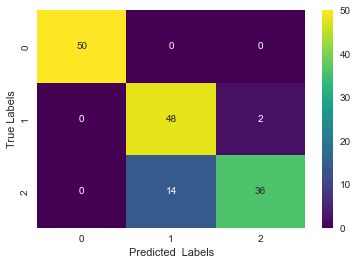

In [17]:
ax = sns.heatmap(confusion_matrix_km, annot=True, cmap="viridis")
ax.set(xlabel="Predicted  Labels", ylabel="True Labels")
confusion_matrix_path_km = "iris_data\confusion_matrix_KM.png"
fig = ax.get_figure()
fig.savefig(confusion_matrix_path_km) 

# MLFlow Kmeans

In [18]:
accuracy_km = df_report_km.loc['accuracy'].mean()
metrics_km = df_report_km.iloc[0:3,:]
precision_km = metrics_km['precision'].mean()
recall_km = metrics_km['recall'].mean()
f1_score_km = metrics_km['f1-score'].mean()

run_metrics_km = {'accuracy': accuracy_km,
                  'precision': precision_km, 
                  'recall': recall_km, 
                  'f1_score': f1_score_km}
run_metrics_km

{'accuracy': 0.8933333333333333,
 'precision': 0.9071873231465761,
 'recall': 0.8933333333333332,
 'f1_score': 0.8917748917748917}

In [19]:
experiment_name_km = "KM_classif" 
environment_km = 'Prod' if accuracy_km >= to_PROD_score else 'Dev'
# run_name="run_name_to_add"

create_experiment(experiment_name = experiment_name_km, 
                  run_metrics = run_metrics_km, 
                  model = model_km, 
                  envir = environment_km,
                  confusion_matrix_path = confusion_matrix_path_km) 

2022/10/28 14:51:09 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



# Logistic Regression

In [20]:
#searching for the best model

param_grid_lr = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  'penalty': [ 'l2'],
                  'multi_class': ['auto', 'ovr'],
                  'C': [0.01, 0.1, 1, 10, 100]}

cv_lr = KFold(n_splits=5)

grid_lr = RandomizedSearchCV(estimator = LogisticRegression(), param_distributions = param_grid_lr, scoring='accuracy',
                             n_iter = 7, cv = cv_lr, verbose=2, n_jobs = -1)
grid_lr.fit(X_train_scaled, y_train)

print('LR best Parameters:', grid_lr.best_estimator_)
print('LR best Score:', grid_lr.best_score_)
best_model_lr = grid_lr.best_estimator_.set_params()

best_model_lr

Fitting 5 folds for each of 7 candidates, totalling 35 fits
LR best Parameters: LogisticRegression(C=10)
LR best Score: 0.9666666666666668


LogisticRegression(C=10)

In [21]:
#retraining the best model

best_model_lr.fit(X_train_scaled, y_train)
y_best_pred_lr = best_model_lr.predict(X_test_scaled)
y_best_pred_proba_lr = best_model_lr.predict_proba(X_test_scaled)
class_report_lr = classification_report(y_test, y_best_pred_lr, output_dict=True)
confusion_matrix_lr = confusion_matrix(y_test, y_best_pred_lr)

pickle.dump(best_model_lr, open("iris_models\iris_model_LR.pkl", "wb"))

print('Confusion Matrix:\n', confusion_matrix_lr)

df_report_lr = pd.DataFrame(class_report_lr).transpose()
df_report_lr.index.names = ['class']
df_report_lr.to_csv('iris_data\iris_report_LR.csv')
df_report_lr

accuracy_lr = df_report_lr.loc['accuracy'].mean()

Confusion Matrix:
 [[10  0  0]
 [ 0  8  1]
 [ 0  1 10]]


<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

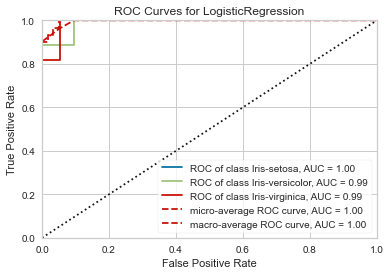

In [22]:
visualizer = ROCAUC(best_model_lr, classes=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
roc_auc_path_lr = "iris_data/roc_auc_LR.jpg"

visualizer.fit(X_train_scaled, y_train)               # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)               # Evaluate the model on the test data
visualizer.show(outpath=roc_auc_path_lr)             # Finalize and render the figure

# MLFlow LR

{'accuracy': 0.933, 'precision': 0.933, 'recall': 0.933, 'f1': 0.933}


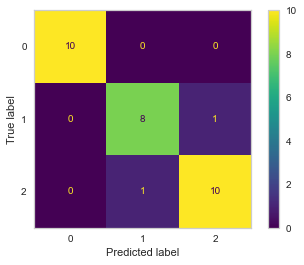

In [23]:
experiment_name_lr = "LR_classif" 
environment_lr = 'Prod' if accuracy_lr >= to_PROD_score else 'Dev'
# run_name="run_name_to_add"
confusion_matrix_path_lr = 'iris_data\confusion_matrix_LR.png'

run_metrics_lr = get_metrics(y_test, y_best_pred_lr, y_best_pred_proba_lr)
print(run_metrics_lr)

create_confusion_matrix_plot(best_model_lr, X_test_scaled, y_test, confusion_matrix_path_lr)

create_experiment(experiment_name = experiment_name_lr, 
                  run_metrics = run_metrics_lr, 
                  model = best_model_lr, 
                  envir = environment_lr,
                  confusion_matrix_path = confusion_matrix_path_lr,
                  roc_auc_path =  roc_auc_path_lr)

# Support Vector Machine

In [24]:
#searching for the best model

param_grid_svm = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'kernel': ['linear', 'rbf','poly'],
                  'gamma' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

cv_svm = KFold(n_splits=5)

grid_svm = RandomizedSearchCV(estimator = SVC(), param_distributions = param_grid_svm, scoring='accuracy',
                             n_iter = 7, cv = cv_svm, verbose=2, n_jobs = -1)
grid_svm.fit(X_train_scaled, y_train)

print('SVM best Parameters:', grid_svm.best_estimator_)
print('SVM best Score:', grid_svm.best_score_)
best_model_svm = grid_svm.best_estimator_.set_params(probability=True)

best_model_svm

Fitting 5 folds for each of 7 candidates, totalling 35 fits
SVM best Parameters: SVC(C=1000, gamma=0.001)
SVM best Score: 0.9666666666666668


SVC(C=1000, gamma=0.001, probability=True)

In [25]:
#retraining the best model

best_model_svm.fit(X_train_scaled, y_train)
y_best_pred_svm = best_model_svm.predict(X_test_scaled)
y_best_pred_proba_svm = best_model_svm.predict_proba(X_test_scaled)
class_report_svm = classification_report(y_test, y_best_pred_svm, output_dict=True)
confusion_matrix_svm = confusion_matrix(y_test, y_best_pred_svm)

pickle.dump(best_model_svm, open("iris_models\iris_model_SVM.pkl", "wb"))

print('Confusion Matrix:\n', confusion_matrix_svm)

df_report_svm = pd.DataFrame(class_report_svm).transpose()
df_report_svm.index.names = ['class']
df_report_svm.to_csv('iris_data\iris_report_SVM.csv')
df_report_svm

accuracy_svm = df_report_svm.loc['accuracy'].mean()

Confusion Matrix:
 [[10  0  0]
 [ 0  8  1]
 [ 0  2  9]]


<AxesSubplot: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

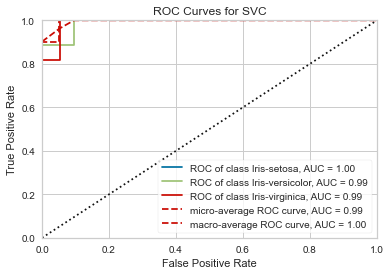

In [26]:
visualizer = ROCAUC(best_model_svm, classes=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
roc_auc_path_svm = "iris_data/roc_auc_SVM.jpg"

visualizer.fit(X_train_scaled, y_train)               # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)               # Evaluate the model on the test data
visualizer.show(outpath=roc_auc_path_svm)             # Finalize and render the figure

# MLFlow SVM

{'accuracy': 0.9, 'precision': 0.903, 'recall': 0.9, 'f1': 0.9}


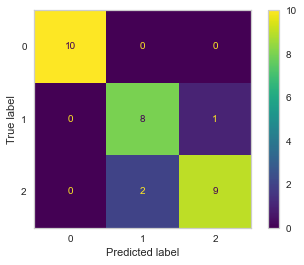

In [27]:
experiment_name_svm = "SVM_classif" 
environment_svm = 'Prod' if accuracy_svm >= to_PROD_score else 'Dev'
# run_name="run_name_to_add"
confusion_matrix_path_svm = 'iris_data\confusion_matrix_SVM.png'

run_metrics_svm = get_metrics(y_test, y_best_pred_svm, y_best_pred_proba_svm)
print(run_metrics_svm)

create_confusion_matrix_plot(best_model_svm, X_test_scaled, y_test, confusion_matrix_path_svm)

create_experiment(experiment_name = experiment_name_svm, 
                  run_metrics = run_metrics_svm, 
                  model = best_model_svm, 
                  envir = environment_svm,
                  confusion_matrix_path = confusion_matrix_path_svm,
                  roc_auc_path =  roc_auc_path_svm)

# Random Forest

In [28]:
#searching for the best model

param_grid_rf = {'max_samples': [0.1, 0.2, 0.3, 0.5],
                'max_features': [1, 2, 3, 5],
                'n_estimators':[10, 30, 50, 100],
                 'max_depth': [5, 7, 10],  
                 'min_samples_leaf': [1, 2, 3]}

cv_rf = KFold(n_splits=5)

grid_rf = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid_rf, scoring='accuracy',
                             n_iter = 7, cv = cv_rf, verbose=2, n_jobs = -1)
grid_rf.fit(X_train_notscaled, y_train)

print('RF best Parameters:', grid_rf.best_estimator_)
print('RF best Score:', grid_rf.best_score_)
best_model_rf = grid_rf.best_estimator_ 

best_model_rf

Fitting 5 folds for each of 7 candidates, totalling 35 fits
RF best Parameters: RandomForestClassifier(max_depth=5, max_features=3, max_samples=0.3,
                       n_estimators=50)
RF best Score: 0.975


RandomForestClassifier(max_depth=5, max_features=3, max_samples=0.3,
                       n_estimators=50)

In [29]:
#retraining the best model

best_model_rf.fit(X_train_notscaled.values, y_train)
y_best_pred_rf = best_model_rf.predict(X_test_notscaled.values)
y_best_pred_proba_rf = best_model_rf.predict_proba(X_test_notscaled.values)
class_report_rf = classification_report(y_test, y_best_pred_rf, output_dict=True)
confusion_matrix_rf = confusion_matrix(y_test, y_best_pred_rf)

pickle.dump(best_model_rf, open("iris_models\iris_model_RF.pkl", "wb"))

print('Confusion Matrix:\n', confusion_matrix_rf)

df_report_rf = pd.DataFrame(class_report_rf).transpose()
df_report_rf.index.names = ['class']
df_report_rf.to_csv('iris_data\iris_report_RF.csv')
accuracy_rf = df_report_rf.loc['accuracy'].mean()
df_report_rf



Confusion Matrix:
 [[10  0  0]
 [ 0  8  1]
 [ 0  3  8]]


,precision,recall,f1-score,support
class,,,,
0,1.000000,1.000000,1.000000,10.000000
1,0.727273,0.888889,0.800000,9.000000
2,0.888889,0.727273,0.800000,11.000000
accuracy,0.866667,0.866667,0.866667,0.866667
macro avg,0.872054,0.872054,0.866667,30.000000
weighted avg,0.877441,0.866667,0.866667,30.000000


<AxesSubplot: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

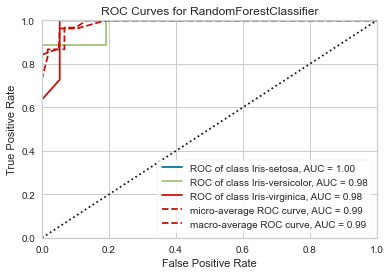

In [30]:
visualizer = ROCAUC(best_model_rf, classes=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
roc_auc_path_rf = "iris_data/roc_auc_RF.jpg"

visualizer.fit(X_train_notscaled.values, y_train)               # Fit the training data to the visualizer
visualizer.score(X_test_notscaled.values, y_test)               # Evaluate the model on the test data
visualizer.show(outpath=roc_auc_path_rf)             # Finalize and render the figure

# ML Flow RF

{'accuracy': 0.867, 'precision': 0.877, 'recall': 0.867, 'f1': 0.867}


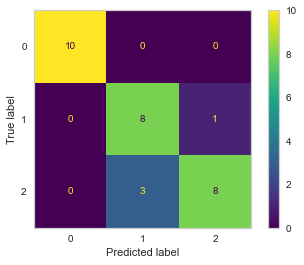

In [31]:
experiment_name_rf = "RF_classif" 
environment_rf = 'Prod' if accuracy_rf >= to_PROD_score else 'Dev'
# run_name="run_name_to_add"
confusion_matrix_path_rf = 'iris_data\confusion_matrix_RF.png'

run_metrics_rf = get_metrics(y_test, y_best_pred_rf, y_best_pred_proba_rf)
print(run_metrics_rf)

create_confusion_matrix_plot(best_model_rf, X_test_notscaled.values, y_test, confusion_matrix_path_rf)

create_experiment(experiment_name = experiment_name_rf, 
                  run_metrics = run_metrics_rf, 
                  model = best_model_rf, 
                  envir = environment_rf,
                  confusion_matrix_path = confusion_matrix_path_rf,
                  roc_auc_path = roc_auc_path_rf) 

# Gradient Boosting

In [32]:
#searching for the best model

param_grid_gb = {'learning_rate': [0.01], #'learning_rate': [0.01, 0.1, 0.5, 1],
                 'n_estimators' : [10, 50, 100, 500, 1000],
                 'max_depth': [2, 5, 8, 11],
                 'max_features': [1,2]}

cv_gb = KFold(n_splits=5)

grid_gb = RandomizedSearchCV(estimator = GradientBoostingClassifier(), param_distributions = param_grid_gb, scoring='accuracy',
                             n_iter = 7, cv = cv_gb, verbose=2, n_jobs = -1)
grid_gb.fit(X_train_notscaled, y_train)

print('GB best Parameters:', grid_gb.best_estimator_)
print('GB best Score:', grid_gb.best_score_)
best_model_gb = grid_gb.best_estimator_ 

best_model_gb

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GB best Parameters: GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features=2,
                           n_estimators=50)
GB best Score: 0.975


GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features=2,
                           n_estimators=50)

In [33]:
#retraining the best model

best_model_gb.fit(X_train_notscaled.values, y_train)
y_best_pred_gb = best_model_gb.predict(X_test_notscaled.values)
y_best_pred_proba_gb = best_model_gb.predict_proba(X_test_notscaled.values)
class_report_gb = classification_report(y_test, y_best_pred_gb, output_dict=True)
confusion_matrix_gb = confusion_matrix(y_test, y_best_pred_gb)

pickle.dump(best_model_gb, open("iris_models\iris_model_GB.pkl", "wb"))

print('Confusion Matrix:\n', confusion_matrix_gb)

df_report_gb = pd.DataFrame(class_report_gb).transpose()
df_report_gb.index.names = ['class']
df_report_gb.to_csv('iris_data\iris_report_GB.csv')
accuracy_gb = df_report_gb.loc['accuracy'].mean()
df_report_gb



Confusion Matrix:
 [[10  0  0]
 [ 0  8  1]
 [ 0  2  9]]


,precision,recall,f1-score,support
class,,,,
0,1.000000,1.000000,1.000000,10.0
1,0.800000,0.888889,0.842105,9.0
2,0.900000,0.818182,0.857143,11.0
accuracy,0.900000,0.900000,0.900000,0.9
macro avg,0.900000,0.902357,0.899749,30.0
weighted avg,0.903333,0.900000,0.900251,30.0


<AxesSubplot: title={'center': 'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

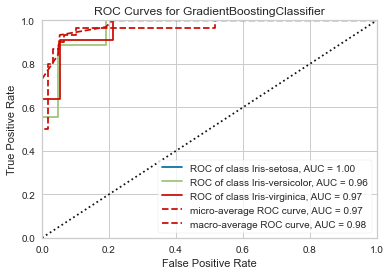

In [34]:
visualizer = ROCAUC(best_model_gb, classes=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
roc_auc_path_gb = "iris_data/roc_auc_GB.jpg"

visualizer.fit(X_train_notscaled.values, y_train)               # Fit the training data to the visualizer
visualizer.score(X_test_notscaled.values, y_test)               # Evaluate the model on the test data
visualizer.show(outpath=roc_auc_path_gb)             # Finalize and render the figure

# ML Flow GB

{'accuracy': 0.9, 'precision': 0.903, 'recall': 0.9, 'f1': 0.9}


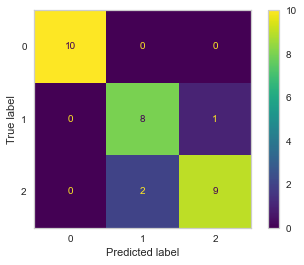

In [35]:
experiment_name_gb = "GB_classif" 
environment_gb = 'Prod' if accuracy_gb >= to_PROD_score else 'Dev'
# run_name="run_name_to_add"
confusion_matrix_path_gb = 'iris_data\confusion_matrix_GB.png'

run_metrics_gb = get_metrics(y_test, y_best_pred_gb, y_best_pred_proba_gb)
print(run_metrics_gb)

create_confusion_matrix_plot(best_model_gb, X_test_notscaled.values, y_test, confusion_matrix_path_gb)

create_experiment(experiment_name = experiment_name_gb, 
                  run_metrics = run_metrics_gb, 
                  model = best_model_gb, 
                  envir = environment_gb,
                  confusion_matrix_path = confusion_matrix_path_gb,
                  roc_auc_path = roc_auc_path_gb) 

# Neural Network

In [36]:
model_nn = Sequential()

model_nn.add(Dense(15, input_shape=(4,), activation='relu', name='hidden_layer_1'))
model_nn.add(Dense(30, activation='relu', name='hidden_layer_2'))
model_nn.add(Dropout(0.1))
model_nn.add(Dense(3, activation='softmax', name='output_layer'))

# Adam optimizer with learning rate of 0.001
optimizer = Adam(lr=0.001)
model_nn.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print('Neural Network Model Summary: ')
print(model_nn.summary())




Neural Network Model Summary: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 15)                75        
                                                                 
 hidden_layer_2 (Dense)      (None, 30)                480       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 output_layer (Dense)        (None, 3)                 93        
                                                                 
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\e105695\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
#Change the label to one hot vector
'''
[0]--->[1 0 0]
[1]--->[0 1 0]
[2]--->[0 0 1]
'''
y_train_nn=np_utils.to_categorical(y_train,num_classes=3)
y_test_nn=np_utils.to_categorical(y_test,num_classes=3)
print("Shape of y_train",y_train.shape)
print("Shape of y_test",y_test.shape)
print("Shape of y_train_nn",y_train_nn.shape)
print("Shape of y_test_nn",y_test_nn.shape)

# Train the model
early_stopping_monitor = EarlyStopping(monitor='loss', patience=5)
model_nn_fitting = model_nn.fit(X_train_scaled, y_train_nn, verbose=0, batch_size=5, epochs=1000, 
                                callbacks=[early_stopping_monitor])

# Test on unseen data
results = model_nn.evaluate(X_test_scaled, y_test_nn)
results

Shape of y_train (120,)
Shape of y_test (30,)
Shape of y_train_nn (120, 3)
Shape of y_test_nn (30, 3)
1/1 [==============================] - 0s 109ms/step - loss: 0.2484 - accuracy: 0.9000


[0.2483643740415573, 0.8999999761581421]

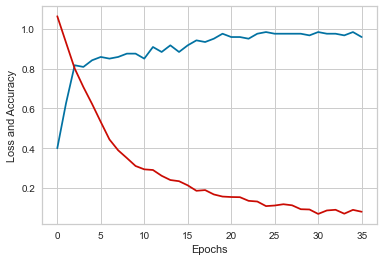

In [38]:
plt.plot(model_nn_fitting.history['accuracy'], 'b', model_nn_fitting.history['loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss and Accuracy')
plt.show()

In [39]:
y_pred_prob=model_nn.predict(X_test_scaled)
y_pred=np.argmax(y_pred_prob,axis=1)

# ct = pd.crosstab(y_pred, y_test)
# print(ct)

class_report_nn = classification_report(y_test, y_pred, output_dict=True)
confusion_matrix_nn = confusion_matrix(y_test, y_pred)

model_nn.save("iris_models\iris_model_NN.h5", "wb")

print('Confusion Matrix:\n', confusion_matrix_nn)

df_report_nn = pd.DataFrame(class_report_nn).transpose()
df_report_nn.index.names = ['class']
df_report_nn.to_csv('iris_data\iris_report_NN.csv')
df_report_nn

1/1 [==============================] - 0s 61ms/step
Confusion Matrix:
 [[10  0  0]
 [ 0  8  1]
 [ 0  2  9]]


,precision,recall,f1-score,support
class,,,,
0,1.000000,1.000000,1.000000,10.0
1,0.800000,0.888889,0.842105,9.0
2,0.900000,0.818182,0.857143,11.0
accuracy,0.900000,0.900000,0.900000,0.9
macro avg,0.900000,0.902357,0.899749,30.0
weighted avg,0.903333,0.900000,0.900251,30.0


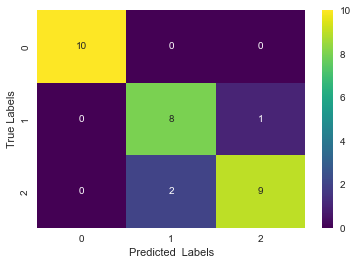

In [40]:
ax = sns.heatmap(confusion_matrix_nn, annot=True, cmap="viridis")
ax.set(xlabel="Predicted  Labels", ylabel="True Labels")
confusion_matrix_path_nn = "iris_data\confusion_matrix_NN.png"
fig = ax.get_figure()
fig.savefig(confusion_matrix_path_nn) 

# MLFlow NN

In [41]:
accuracy_nn = df_report_nn.loc['accuracy'].mean()
metrics_nn = df_report_nn.iloc[0:3,:]
precision_nn = metrics_nn['precision'].mean()
recall_nn = metrics_nn['recall'].mean()
f1_score_nn = metrics_nn['f1-score'].mean()

run_metrics_nn = {'accuracy': accuracy_nn,
                  'precision': precision_nn, 
                  'recall': recall_nn, 
                  'f1_score': f1_score_nn}
run_metrics_nn

{'accuracy': 0.9,
 'precision': 0.9,
 'recall': 0.9023569023569024,
 'f1_score': 0.899749373433584}

In [42]:
experiment_name_nn = "NN_classif" 
environment_nn = 'Prod' if accuracy_nn >= to_PROD_score else 'Dev'
# run_name="run_name_to_add"

create_experiment(experiment_name = experiment_name_nn, 
                  run_metrics = run_metrics_nn, 
                  model = model_nn, 
                  envir = environment_nn,
                  confusion_matrix_path = confusion_matrix_path_nn) 

INFO:tensorflow:Assets written to: ram://cf81a4f4-8810-41ce-b34d-0b60a528c088/assets


2022/10/28 14:51:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\e105695\AppData\Local\Temp\tmpgnbv3pk5\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.2', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback.


# TEST

In [43]:

# randpos=random.sample(range(0, 119), 1)

# print('\ninput:\n',X_train_notscaled.iloc[randpos])

# iris_types = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
# iris_pred = int(best_model_rf.predict(X_train_notscaled.iloc[randpos].values))
# print('\nactual output:\n', int(y_train.iloc[randpos]), '\npredicted output:\n',(iris_pred, iris_types[iris_pred]))

# print('\npredict proba:\n',best_model_rf.predict_proba(X_train_notscaled.iloc[randpos].values))